# Detecção de Fraudes em Cartão de Crédito

Neste projeto, iremos abordar um grande problema das instituições financeiras que são as fraudes em cartões de credito. Todos os anos, milhões de pessoas são vítimas de fraudes financeiras no Brasil e no mundo, sofrendo com prejuízos na casa do bilhões de dólares a nível global. 

As fraudes em cartões de crédito são de grande relevância, uma vez que, se não forem devidamente detectadas, resultará em prejuízos para o consumidor e também para a instituição financeira. 

Outro fator importante, é a quantidade de falsos positivos gerados, ou seja, quando você tenta utilizar o seu cartão e acaba com seu cartão bloqueado de forma preventiva, o que também causa estresse e constrangimento. 

É por isso que instituições financeiras investem cada vez mais em formas de detectar fraudes através do uso de Inteligência Artificial, resultando em um crescimento na área de Data Science. Uma vez que se tenha um grande volume de dados, e um bom algoritmo de machine learning, é possível obter uma economia de milhões de Reais. 

O desafio aqui, é aprimorar cada vez o uso de algoritmos de machine learning com a intenção de evitar novas transações fraudulentas.

## Importando Dados

Os dados utilizados nesse projeto, foram disponibilizados por empresas européias de cartão de crédito. O Dataset é composto das operações registradas durante um período de dois dias, onde foram classificados 492 fraudes em uma lista de aproximadamente 290 mil transações. 

Trata-se de um dataset completamente desbalanceado, uma vez que a quantidade de registros de fraudes representam 0,17% do total dos dados.

Devido à proteção e privacidade dos dados, as features foram todas descaracterizadas, todas são features numéricas. Os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$.

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.


In [3]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

In [4]:
# importar os dados para um dataframe
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

df = pd.read_csv(file_path)

# dimensões do conjunto original
print("Dimensões do Conjunto Original: ", df.shape)

# criando o conjunto de teste
test = df.sample(frac=0.15, random_state=0)

# drop das linhas de teste
df = df.drop(test.index)

# verificando o conjunto
print("Dimensões do Conjunto de Teste: ", test.shape)
print("Dimensões do Conjunto de Treino: ", df.shape)

Dimensões do Conjunto Original:  (284807, 31)
Dimensões do Conjunto de Teste:  (42721, 31)
Dimensões do Conjunto de Treino:  (242086, 31)


## Análise Exploratória

In [5]:
# conferindo as 5 primeiras entradas
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

Conferindo as cinco primeiras entradas do dataset para entender melhor a estrutura do dataset.

*   É possível perceber como a transformação PCA descaracterizaram as features.

*   As colunas `Time` e `Amout` foram preservadas.

*   A variável alvo é a coluna `Class`, onde:
    * **0** Transação Normal;
    * **1** Transação Fraudulenta;


In [6]:
# conferindo o resumo estatístico
df.describe().round(4)

Time           V1           V2           V3           V4  \
count  242086.0000  242086.0000  242086.0000  242086.0000  242086.0000   
mean    94857.5974       0.0015      -0.0008      -0.0010       0.0006   
std     47490.6608       1.9565       1.6549       1.5146       1.4172   
min         0.0000     -56.4075     -72.7157     -33.6810      -5.6832   
25%     54234.0000      -0.9204      -0.5987      -0.8934      -0.8482   
50%     84747.0000       0.0192       0.0646       0.1776      -0.0190   
75%    139362.0000       1.3160       0.8032       1.0266       0.7437   
max    172792.0000       2.4519      22.0577       9.3826      16.8753   

                V5           V6           V7           V8           V9  ...  \
count  242086.0000  242086.0000  242086.0000  242086.0000  242086.0000  ...   
mean       -0.0010      -0.0012      -0.0000      -0.0004      -0.0007  ...   
std         1.3663       1.3269       1.2231       1.1997       1.0993  ...   
min       -42.1479     -26.1605     -43.5572     -73.2167     -13.4341  ...   
25%        -0.6936      -0.7690      -0.5538      -0.2089      -0.6451  ...   
50%        -0.0545      -0.2743       0.0403       0.0222      -0.0514  ...   
75%         0.6115       0.3977       0.5701       0.3272       0.5972  ...   
max        34.8017      23.9178      44.0545      20.0072      15.5950  ...   

               V21          V22          V23          V24          V25  \
count  242086.0000  242086.0000  242086.0000  242086.0000  242086.0000   
mean       -0.0000       0.0006      -0.0005       0.0002       0.0000   
std         0.7342       0.7263       0.6297       0.6052       0.5216   
min       -34.8304     -10.9331     -44.8077      -2.8227     -10.2954   
25%        -0.2285      -0.5430      -0.1619      -0.3545      -0.3169   
50%        -0.0290       0.0072      -0.0112       0.0408       0.0172   
75%         0.1871       0.5298       0.1474       0.4393       0.3508   
max        27.2028      10.5031      22.5284       4.0229       7.5196   

               V26          V27          V28       Amount        Class  
count  242086.0000  242086.0000  242086.0000  242086.0000  242086.0000  
mean       -0.0003      -0.0007       0.0001      88.6124       0.0017  
std         0.4821       0.4015       0.3277     247.6550       0.0415  
min        -2.6046     -22.5657     -11.7109       0.0000       0.0000  
25%        -0.3274      -0.0707      -0.0529       5.6625       0.0000  
50%        -0.0523       0.0011       0.0112      22.0000       0.0000  
75%         0.2412       0.0908       0.0782      77.5800       0.0000  
max         3.5173      12.1524      33.8478   19656.5300       1.0000  

[8 rows x 31 columns]

Observando a Coluna `Amount` nota-se que, o valor médio das transações é de $88,61, já a mediana é de $22,00, e o desvio padrão é de 247,65, e o valor máximo registrado é de 19656,53. 

Ou seja, a maioria das transações que são realizadas, são compostas de baixas quantias de dinheiro. Uma vez que a mediana está na casa dos $22,00, isso significa que metade das transações são abaixo desse valor. 

In [7]:
# conferindo se há valores ausentes
df.isnull().sum().max()

0

O dataset não apresenta valores nulos ou ausentes, portanto não será necessário qualquer tipo de limpeza. 

Como foi informado anteriormente, a quantidade de dados referente à fraudes são muito poucas em relação ao dataset.

Confira no gráfico abaixo o quão grande é a discrepância desse conjunto de dados. 

In [8]:
# Conferindo o balanceamento dos dados
print(f"Quantidade de entradas 'Normais [0]': \t\t{df[df.Class ==0].shape[0]}")
print(f"Quantidade de entradas 'Fraudulentas [1]': \t{df[df.Class ==1].shape[0]}")
print("\nFraudes representam {:.4f}% do dataset.\n".format((df[df.Class==1].shape[0] / df.shape[0]) * 100))

Quantidade de entradas 'Normais [0]': 		241668
Quantidade de entradas 'Fraudulentas [1]': 	418

Fraudes representam 0.1727% do dataset.



[]

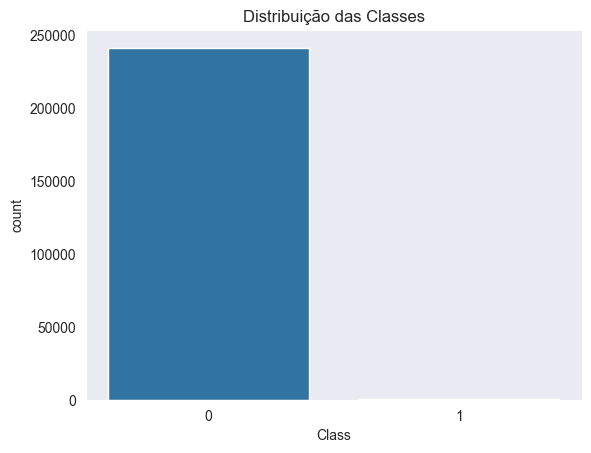

In [9]:
# plotando gráfico da coluna Classes
fig, ax = plt.subplots()
sns.countplot(x="Class", data=df, ax=ax)
ax.set_title("Distribuição das Classes")
plt.plot()

Agora plotamos alguns histogramas para comparar as distribuições de ambas as classes

Primeiro o histograma em função do tempo, esperava-se encontrar algum padrão em relação ao horário em que as fraudes ocorriam, porém não foi possível obter nenhuma informação significativa.

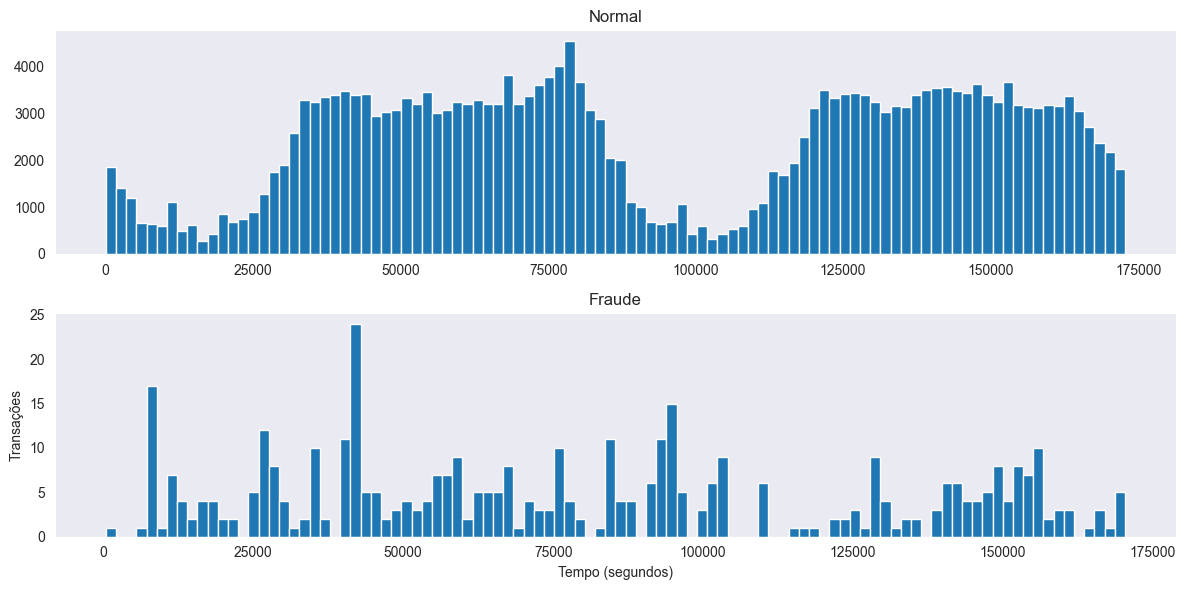

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

num_bins = 100

ax[0].hist(df.Time[df.Class == 0], bins=num_bins)
ax[0].set_title("Normal")

ax[1].hist(df.Time[df.Class == 1], bins=num_bins)
ax[1].set_title("Fraude")

plt.xlabel("Tempo (segundos)")
plt.ylabel("Transações")
plt.tight_layout()

Dando continuidade à análise exploratória, foi plotado o BoxPlot para as classes em relação à feature `Amount`, dessa forma é possível ver a diferença na distribuição dos dados.

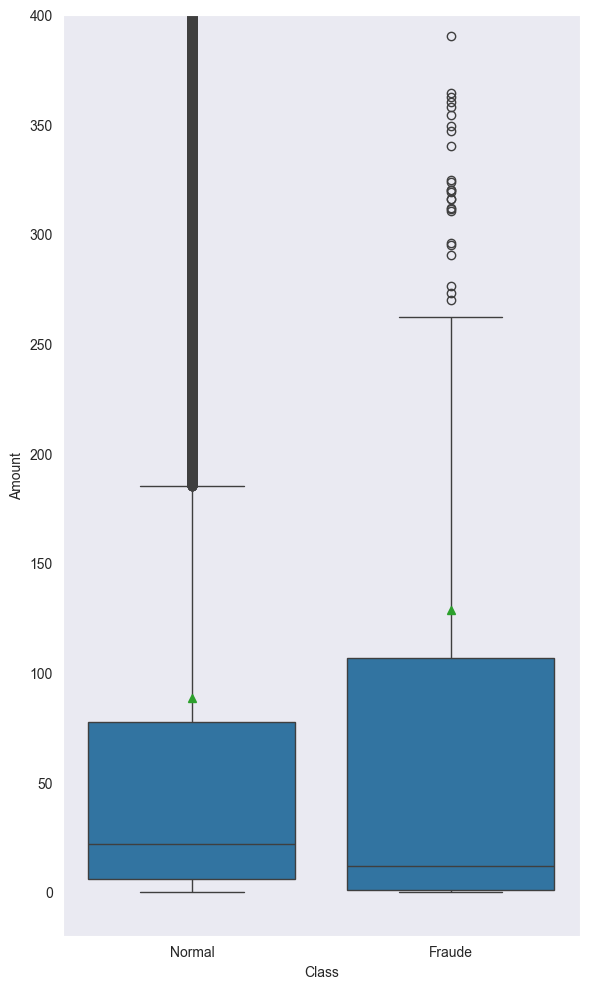

In [11]:
fig, ax = plt.subplots(figsize=(6,10), sharex=True)

sns.boxplot(x="Class", y="Amount", data=df, showmeans=True)
plt.ylim((-20,400))
plt.xticks([0,1], ["Normal", "Fraude"])

plt.tight_layout()

As estatíticas do Dataset indicam que a média das transações fraudulentas são de 128,49, enquanto a mediana está na casa dos 11,85.

In [12]:
df[df.Class == 1]["Amount"].describe()

count     418.000000
mean      128.496722
std       267.731154
min         0.000000
25%         1.000000
50%        11.855000
75%       106.812500
max      2125.870000
Name: Amount, dtype: float64

Já para as transações normais, a média é de 88,54 enquanto a mediana esta na casa dos 22,00. 

In [13]:
df[df.Class == 0]["Amount"].describe()


count    241668.000000
mean         88.543443
std         247.613919
min           0.000000
25%           5.700000
50%          22.000000
75%          77.500000
max       19656.530000
Name: Amount, dtype: float64

Agora vamos conferir a densidade das variáveis do dataset, para então compararmos as distribuições de cada uma das variáveis e observar quais delas apresentam maiores anomalias.

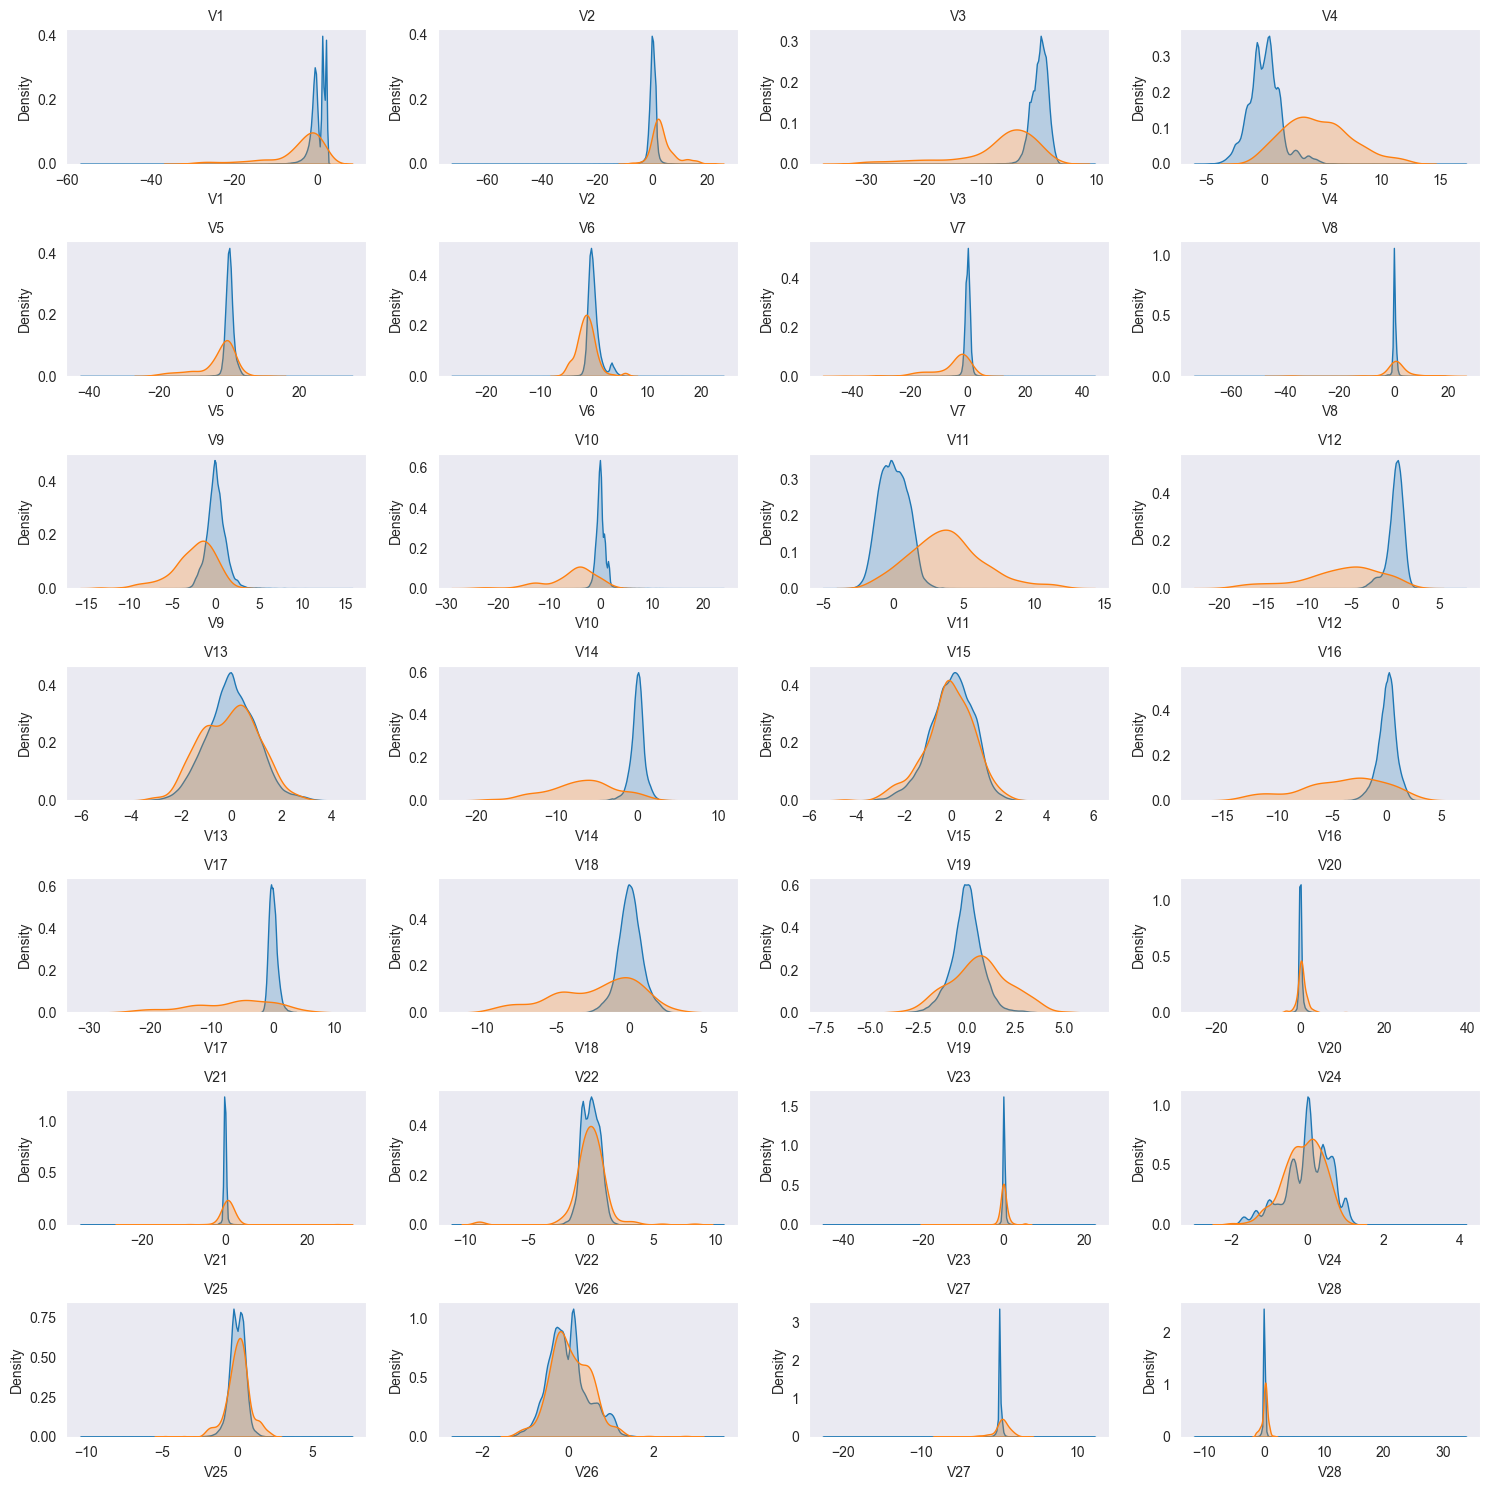

In [14]:
column_names = df.drop(["Class", "Amount", "Time"], axis=1).columns
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(15,15))
fig.subplots_adjust(hspace=1, wspace=1)

indx = 0
for col in column_names:
    indx += 1
    plt.subplot(7, 4, indx)
    sns.kdeplot(df_class_0[col], label="Class 0", fill=True) 
    sns.kdeplot(df_class_1[col], label="Class 1", fill=True) 
    plt.title(col, fontsize=10)
plt.tight_layout()

Esse tipo de visualização nos permite comparar a distribuição de cada classe para cada uma das variáveis, facilitando a identificação de anomalias entre elas. 

Note como as variáveis `V8`,`V13`,`V15`,`V22`,`V25` e `V28` apresentam um comportamento muito parecido entre si. Já o contrário pode ser observado nas variáveis `V3`, `V4`,`V10`,`V11` e `V14`, são distintas entre si, o que pode indicar a possível fonte de anomalias.

## Preparando os Dados

Para o problema em questão, de detecção de fraudes, vamos utilizar modelos de Classificação para identificar a variável alvo. Para seguir com a construção do modelo, vamos seguir os seguintes passos:

*   Padronizar as Features `Time` e `Amount`, que estão em outra ordem de grandeza.

*   Dividir os dados entre `Treino` e `Teste`.

*   Balancear os dados a fim de evitar uma baixa performance para a classe 1 e overfitting.


### Padronizando `Time`e `Amount`

Como foi identificado a presença de `outliers` na coluna `Amount`, será uitilizado a padronização por meio da classe `StandardScaler`.


In [15]:
df_clean = df.copy()

std_scaler = StandardScaler()
df_clean["std_amount"] = std_scaler.fit_transform(df_clean["Amount"].values.reshape(-1,1))
df_clean["std_time"] = std_scaler.fit_transform(df_clean["Time"].values.reshape(-1,1))

df_clean.drop(["Time","Amount"],axis=1, inplace=True)

df_clean.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Class  std_amount  std_time  
0 -0.189115  0.133558 -0.021053      0    0.246341 -1.997399  
1  0.125895 -0.008983  0.014724      0   -0.346945 -1.997399  
2 -0.139097 -0.055353 -0.059752      0    1.171178 -1.997378  
3 -0.221929  0.062723  0.061458      0    0.140872 -1.997378  
4  0.502292  0.219422  0.215153      0   -0.075195 -1.997357  

[5 rows x 31 columns]

### Separando entre `Treino` e `Teste`

In [16]:
# Separar variáveis entre X e y
X = df_clean.drop("Class",axis=1)   # Features
y= df_clean["Class"]                # Target

In [17]:
# Separando entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

Vamos utilizar da biblioteca `imblearn` o método `SMOTE` para balancear os dados.

In [18]:
# Balanceamento utilizando SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

Agora que temos os dados balanceados, vamos conferir a matriz de correlação para ver como as features estão se relacionando.

Observe como que sem o balanceamento dos dados, a matriz de correlção não traz informações relevantes.

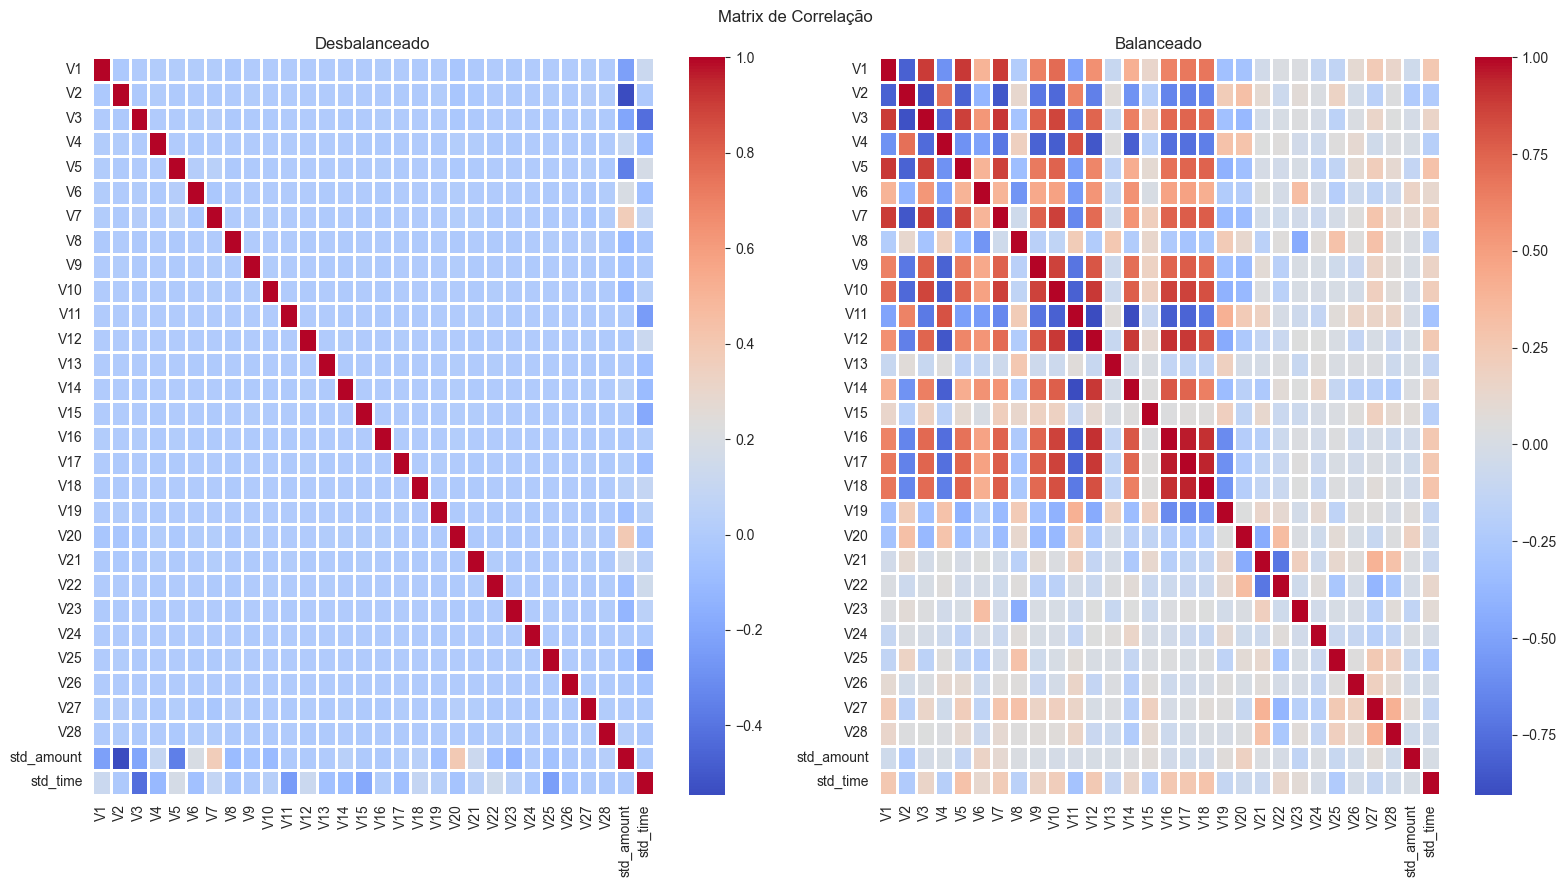

In [22]:
# Matriz de Correlação
corr = X_train.corr()
corr_bal = pd.DataFrame(X_train_bal).corr()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,9))
fig.suptitle("Matrix de Correlação")

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidth=1, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Desbalanceado")

sns.heatmap(corr_bal, xticklabels=corr.columns, yticklabels=corr.columns, linewidth=1, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Balanceado")


plt.tight_layout()

In [23]:
# Selecionando modelos à serem avaliados
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Bossting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier()    
}

In [24]:
# Treinamento e avaliação

for nome, modelo in modelos.items():
    modelo.fit(X_train_bal, y_train_bal)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]
    
    print(f"\n {nome}")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))


 Logistic Regression
              precision    recall  f1-score   support

           0     0.9999    0.9747    0.9871     72501
           1     0.0600    0.9360    0.1128       125

    accuracy                         0.9747     72626
   macro avg     0.5300    0.9554    0.5500     72626
weighted avg     0.9983    0.9747    0.9856     72626

ROC AUC 0.9883864774278976
Confusion Matrix: 
 [[70669  1832]
 [    8   117]]

 Random Forest
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     72501
           1     0.9159    0.7840    0.8448       125

    accuracy                         0.9995     72626
   macro avg     0.9578    0.8919    0.9223     72626
weighted avg     0.9995    0.9995    0.9995     72626

ROC AUC 0.9807758237817409
Confusion Matrix: 
 [[72492     9]
 [   27    98]]

 Gradient Bossting
              precision    recall  f1-score   support

           0     0.9998    0.9884    0.9941     72501
           1     0.1186

/Users/marcoasilva/Documents/DSNP/dsnpvenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:49:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 XGBoost
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     72501
           1     0.8320    0.8320    0.8320       125

    accuracy                         0.9994     72626
   macro avg     0.9159    0.9159    0.9159     72626
weighted avg     0.9994    0.9994    0.9994     72626

ROC AUC 0.9771438187059488
Confusion Matrix: 
 [[72480    21]
 [   21   104]]
[LightGBM] [Info] Number of positive: 169167, number of negative: 169167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 338334, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

 LightGBM
              precision    recall  f1-score   support

           0     0.9997    0.9991    0.9994     72501
           1     0.6220

In [26]:
def plot_roc_curve(y_test, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")
    
def plot_pr_curve(y_test, y_proba, model_name):
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{model_name} (AUC = {pr_auc:.4f})")

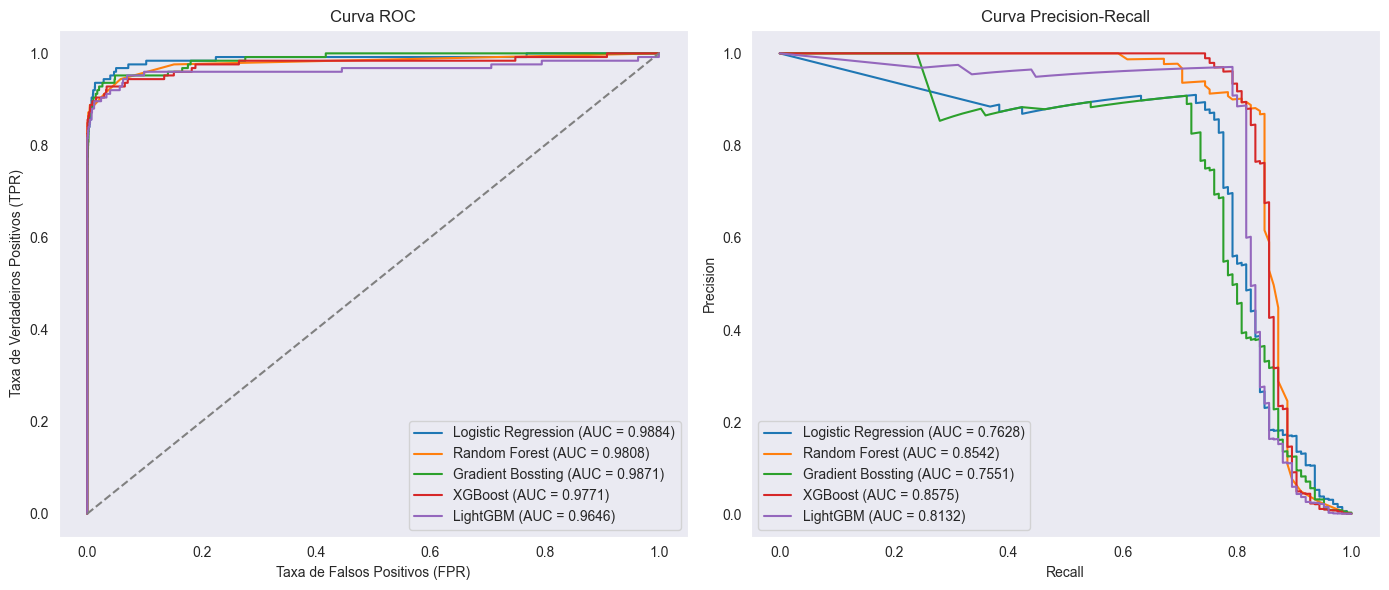

In [27]:
plt.figure(figsize=(14, 6))

# ROC
plt.subplot(1, 2, 1)
for nome, modelo in modelos.items():
    y_proba = modelo.predict_proba(X_test)[:, 1]
    plot_roc_curve(y_test, y_proba, nome)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("Curva ROC")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.legend()

# PR
plt.subplot(1, 2, 2)
for nome, modelo in modelos.items():
    y_proba = modelo.predict_proba(X_test)[:, 1]
    plot_pr_curve(y_test, y_proba, nome)
plt.title("Curva Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()


| Modelo | ROC AUC | PR AUC | Observação técnica | 
| --- | --- | --- | --- | 
| Logistic Regression | 0.9884 | 0.7628 | Alta separabilidade, mas **precision fraca** → muitos falsos positivos | 
| Random Forest | 0.9808 | 0.8542 | Excelente equilíbrio → poucos FP e boa detecção de fraudes | 
| Gradient Boosting | 0.9871 | 0.7551 | Alta ROC, mas **precision baixa** → similar à regressão logística | 
| XGBoost | 0.9771 | 0.8575 | **Melhor PR AUC** → foco total na **detecção eficaz de fraudes com poucos erros** | 
| LightGBM | 0.9646 | 0.8132 | Levemente inferior, mas ainda **altamente competitivo** |



### 📊 **Resumo Comparativo** 
| Modelo | Precision | Recall | F1-Score | ROC AUC | FP | FN | 
| --- | --- | --- | --- | --- | --- | --- | 
| **LogisticRegression** | 0.0600 | **0.9360** | 0.1128 | **0.9884** | 1832 | **8** | 
| **RandomForest** | **0.9159** | 0.7840 | **0.8448** | 0.9808 | **9** | 27 | 
| **GradientBoosting** | 0.1186 | 0.9040 | 0.2096 | 0.9871 | 840 | 12 | 
| **XGBoost** | 0.8320 | 0.8320 | 0.8320 | 0.9771 | 21 | 21 | 
| **LightGBM** | 0.6220 | 0.8160 | 0.7059 | 0.9646 | 62 | 23 |



### 🎯 Interpretação Estratégica 

* ✅ **Logistic Regression** tem recall altíssimo (0.9360) e AUC excelente (0.988), mas **precision baixíssima**. Ótimo para **não deixar passar fraudes**, mas há **muitos falsos positivos** (1832). 

* ✅ **Random Forest** tem o melhor equilíbrio: **precision alta (0.91)**, recall sólido (0.784) e f1 excelente (0.8448). Quase nenhum falso positivo ou negativo. 

* 🔍 **Gradient Boosting** tem bom recall (0.90), mas baixa precision, sugerindo **alertas excessivos**. 

* 💪 **XGBoost** apresenta **equilíbrio perfeito (0.83/0.83)** — excelente escolha prática com boa precisão e recall. 

* 🔥 **LightGBM** performa bem, mas com precisão mais baixa. Trade-off maior entre falso positivo e negativo.



### ✅ Recomendação 

🔹 **Uso Sensível à Fraude (Bancos, seguradoras, etc):** 

* **Logistic Regression** (quando o recall absoluto é prioridade — ex: evitar fraude a qualquer custo). 

* **XGBoost** / **Random Forest** quando se deseja **reduzir alarmes falsos sem perder recall**.



### ✅ Conclusão Técnica 
| Métrica-chave | Melhor Modelo | Justificativa | 
| --- | --- | --- | 
| **Separação Geral (ROC AUC)** | Logistic Regression | Altíssimo recall, separação clara | 
| **Detecção de Fraudes (PR AUC)** | XGBoost / Random Forest | Maior precisão com recall alto | 
| **Trade-off FP vs FN** | Random Forest / LightGBM | F1 equilibrado e poucos falsos positivos |



De todos os modelos testados, o modelo de `Random Forest` foi o que apresentou os resultados de forma mais equilibrada, com menos falso positivo e isso é  bom uma vez que não irá causar transtornos quando um cliente tenta realizar uma compra e tem seu cartão recusado. 

Mas por se tratar de um ambiente financeiro, o transtorno causado por um falso negativo, ou seja, quando o cartão está sendo fraudado mas o modelo não reconhece como fraude, isso pode gerar um prejuízo absurdo, e um transtorno ainda maior para o cliente.

In [36]:
print(f"A soma do valor de todas as fraudes do Dataset é de ${df[df["Class"] == 1]["Amount"].sum()}")

A soma do valor de todas as fraudes do Dataset é de $53711.63


Somente no dataset analisado, que representa os dados de apenas dois dias de transações, o valor fraudado foi de $53.711,63.

Agora imagine isso ao longo de um ano, o transtorno causado pelo prejuizo pode ser muito maior do que o transtorno causado ao ter uma compra recusada.